# Multiclass Semantic Segmentation using CamVid dataset

## Introduction
- Semantic Segmentation of an image is to assign each pixel in the input image a semantic class in order to get a pixel-wise dense classification.
- A general semantic segmentation architecture can be broadly thought of as an encoder network followed by a decoder network. - - The encoder is usually is a pre-trained classification network like VGG/ResNet followed by a decoder network. The decoder network/mechanism is mostly where these architectures differ. 
- The task of the decoder is to semantically project the discriminative features (lower resolution) learnt by the encoder onto the pixel space (higher resolution) to get a dense classification. (mechanisms like skip connections, pyramid pooling etc are used for this)



## Importing libraries

In [1]:
from Segmentation_functions import *
import tensorflow.keras.backend as K
import tensorflow as tf
%matplotlib inline


# Environment checks

In [2]:
print(tf.__version__)
tf.enable_eager_execution()

x = tf.random.uniform([3, 3])
print(tf.executing_eagerly())

1.14.0
True


### Image directory and size parameters

In [13]:
img_dir = 'data/'
#img_dir = 'data_white/'

#standard
#MODEL_FCN32 = "camvid_model_FCN32.h5"
#MODEL_FCN16 = "camvid_model_FCN16_v1.h5"
#MODEL_FCN8 = "camvid_model_FCN8_v1.h5"
#MODEL_SEGNET = "camvid_model_vgg16_segnet_v1_aug.h5"
#MODEL_UNET = "camvid_model_Unet_v1_aug.h5"

# white
#MODEL_FCN32 = "camvid_model_FCN32_whitehole.h5"
#MODEL_FCN16 = "camvid_model_FCN16_white.h5"
#MODEL_FCN8 = "camvid_model_FCN8_white.h5"
#MODEL_SEGNET = "camvid_model_vgg16_segnet_v1_white.h5"
#MODEL_UNET = "camvid_model_Unet_v1_white.h5"

#epochs
MODEL_FCN_50 = "camvid_model_FCN32_v1_e50.h5"
MODEL_FCN_100 ="camvid_model_FCN32.h5"
MODEL_FCN_200 ="camvid_model_FCN32_v1_e200.h5"

# Required image dimensions
output_height = 1120
output_width = 1504

### Parse and extract label names and codes

In [14]:
label_codes = [(176,112,32),(176,240,32),(48,112,32),(112,112,32),(48,240,32),(176,240,160),(176,112,160),(48,112,160),(48,240,160),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40),(50,50,40)]
label_names = ['Cortical subplate','Hypothalamus','Cerebral nuclei','auditory area','Hippocampal formation','Thalamus','Retrosplenial area','Olfactory area','Somatosensory area','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump']


#label_codes = [(255,128,0),(181,230,29),(0,0,0),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),(1,1,1),]
#label_names = ['Crinoid','back','black','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump','dump']
label_codes[:5], label_names[:5]

([(176, 112, 32),
  (176, 240, 32),
  (48, 112, 32),
  (112, 112, 32),
  (48, 240, 32)],
 ['Cortical subplate',
  'Hypothalamus',
  'Cerebral nuclei',
  'auditory area',
  'Hippocampal formation'])

### Create useful label and code conversion dictionaries
_These will be used for:_
- One hot encoding the mask labels for model training
- Decoding the predicted labels for interpretation and visualization

In [15]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}
name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

# Creating custom Image data generators

### Defining data generators

In [16]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255, brightness_range=[0.6,1.4])
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

test_frames_datagen = ImageDataGenerator(**data_gen_args)
test_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

# Defining Models for semantic segmentation

In [17]:
os.getcwd()

'/home/mirap/tensorflowGUI/alpha/Multiclass-Semantic-Segmentation-CamVid'

### Function to create FCN-32 model, using VGG-16 pre-trained weights

In [18]:
# FCN 32s
#model32 = FCN32( 32 ,  input_height=224, input_width=224 , vgg_level=3)

# FCN 16s
#model16 = FCN16( 32 ,  input_height=224, input_width=224)

# FCN 8s
#model8 = FCN8( 32 ,  input_height=224, input_width=224)

# SegNet
#modelSegNet = VGGSegnet( 32  , vgg_level=3)

# U Net
#modelU_Net = get_small_unet(n_filters=32)

#epochs
model_e50 = FCN32( 32 ,  input_height=224, input_width=224 , vgg_level=3)
model_e100 = FCN32( 32 ,  input_height=224, input_width=224 , vgg_level=3)
model_e200 = FCN32( 32 ,  input_height=224, input_width=224 , vgg_level=3)

## Compiling model
- Using categorical crossentropy loss since labels have been one hot encoded

In [19]:
# model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tversky_loss,dice_coef,recall,precision,iou,'accuracy'])
OPTIMIZER='adam'
LOSS="categorical_crossentropy"
METRICS=[tversky_loss,dice_coef,tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),iou,'accuracy']

# Compile Models
#model32.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
#model16.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
#model8.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
#modelSegNet.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
#modelU_Net.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

#epochs
model_e50.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
model_e100.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
model_e200.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)


In [20]:
#Load weights to Models 
#model32.load_weights(MODEL_FCN32)
#model16.load_weights(MODEL_FCN16)
#model8.load_weights(MODEL_FCN8)
#modelSegNet.load_weights(MODEL_SEGNET)
#modelU_Net.load_weights(MODEL_UNET)

#epochs
model_e50.load_weights(MODEL_FCN_50)
model_e100.load_weights(MODEL_FCN_100)
model_e200.load_weights(MODEL_FCN_200)

# Model Evaluation

In [27]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)

### Extract and display model frame, prediction and mask batch

In [22]:
batch_img,batch_mask = next(testing_gen)

#pred_32= model32.predict(batch_img)
#pred_16= model16.predict(batch_img)
#pred_8= model8.predict(batch_img)
#pred_SegNet= modelSegNet.predict(batch_img)
#pred_U_Net= modelU_Net.predict(batch_img)

pred_e50= model_e50.predict(batch_img)
pred_e100= model_e100.predict(batch_img)
pred_e200= model_e200.predict(batch_img)

#np.shape(pred_32)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


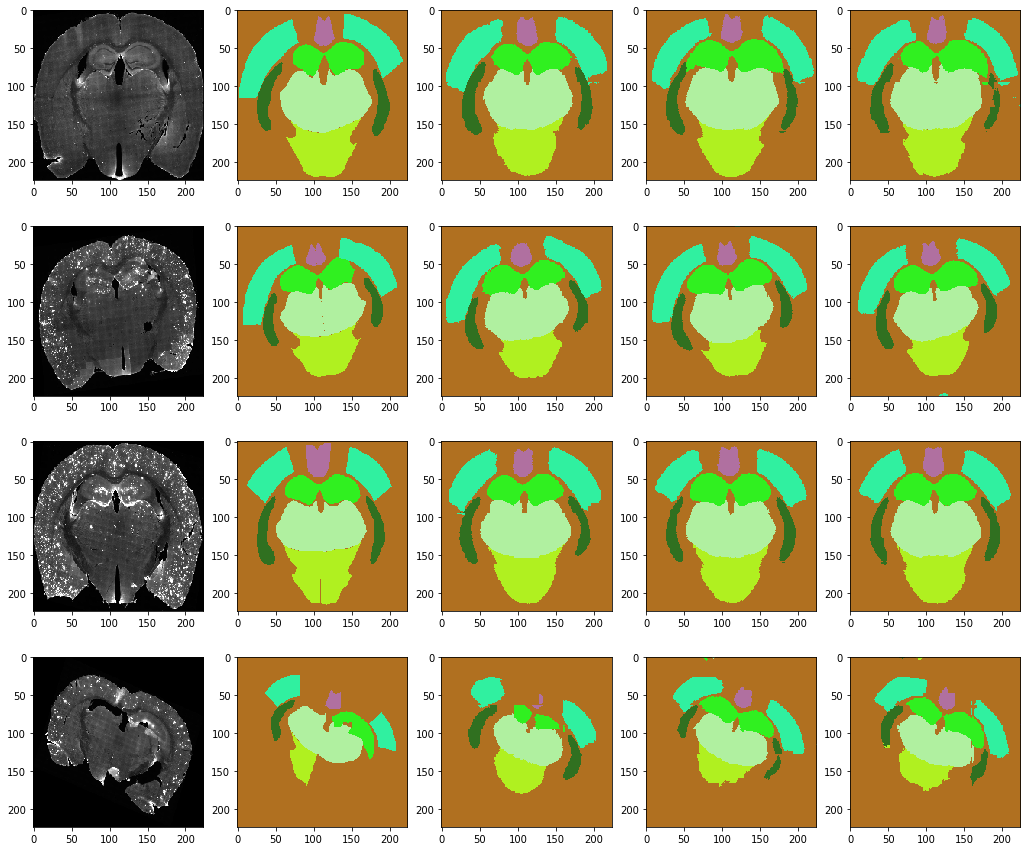

In [21]:
rows = np.shape(pred_e200)[0]

fig = plt.figure(figsize=(25,rows*3.8))

for i in range(0,rows):
    
    ax1 = fig.add_subplot(rows,7,i*7+1)
    ax1.imshow(batch_img[i])
    #ax1.title.set_text('Actual frame')
    #ax1.grid(b=None)
        
    ax2 = fig.add_subplot(rows,7,i*7+2)
    #ax2.set_title('Ground truth')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    #ax2.grid(b=None)
    
    ax3 = fig.add_subplot(rows,7,i*7+3)
    #ax3.set_title('FCN32s')
    ax3.imshow(onehot_to_rgb(pred_e50[i],id2code))
    #ax3.grid(b=None)
    
    ax4 = fig.add_subplot(rows,7,i*7+4)
    #ax4.set_title('FCN16s')
    ax4.imshow(onehot_to_rgb(pred_e100[i],id2code))
    #ax4.grid(b=None)
    
    ax5 = fig.add_subplot(rows,7,i*7+5)
    #ax5.set_title('FCN8s')
    ax5.imshow(onehot_to_rgb(pred_e200[i],id2code))
    #ax5.grid(b=None)
    
plt.savefig("epochs_result", dpi=300)
plt.show()

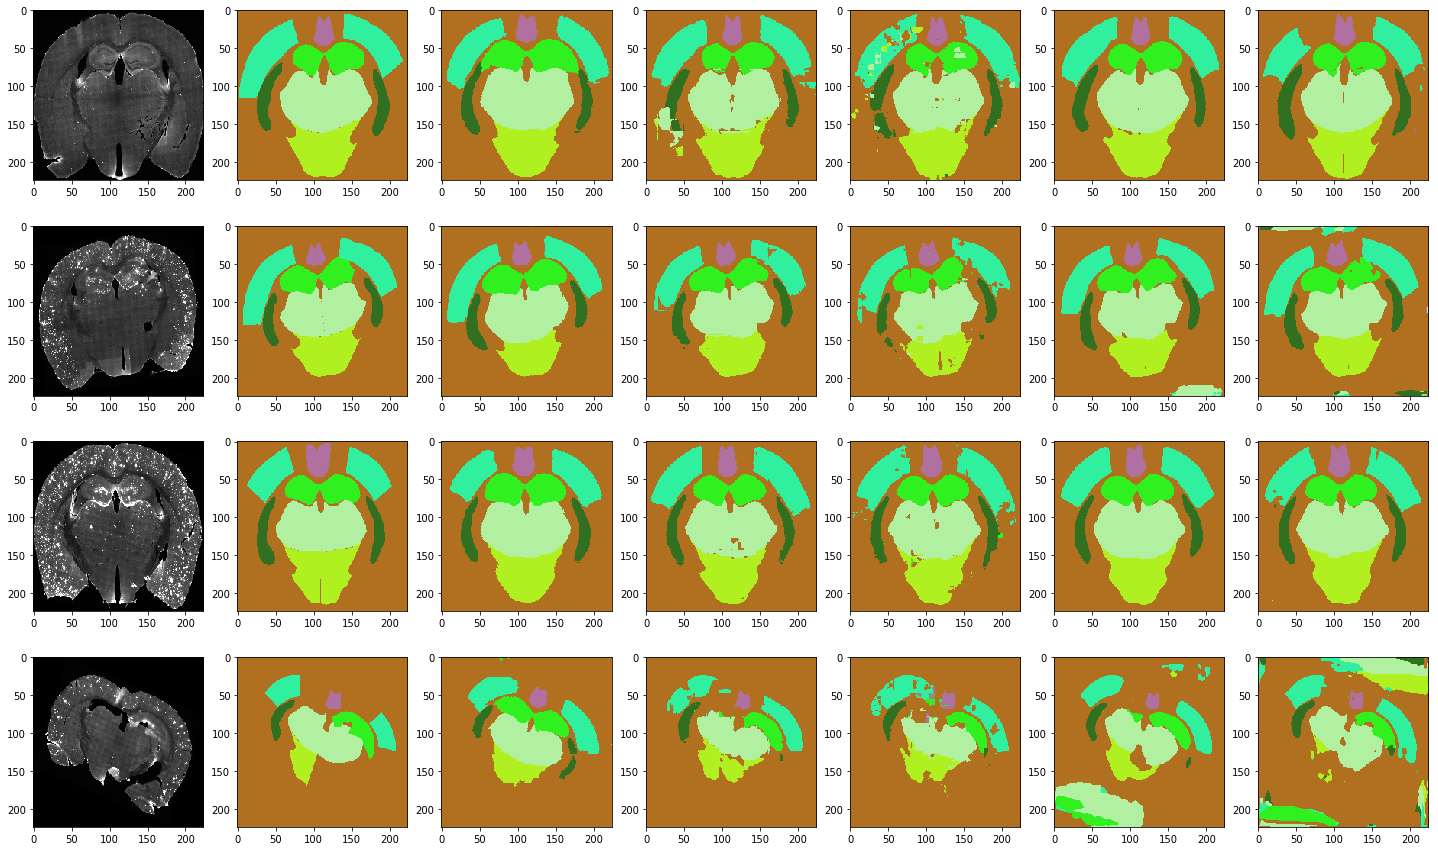

In [57]:
rows = np.shape(pred_32)[0]

fig = plt.figure(figsize=(25,rows*3.8))

for i in range(0,rows):
    
    ax1 = fig.add_subplot(rows,7,i*7+1)
    ax1.imshow(batch_img[i])
    #ax1.title.set_text('Actual frame')
    #ax1.grid(b=None)
        
    ax2 = fig.add_subplot(rows,7,i*7+2)
    #ax2.set_title('Ground truth')
    ax2.imshow(onehot_to_rgb(batch_mask[i],id2code))
    #ax2.grid(b=None)
    
    ax3 = fig.add_subplot(rows,7,i*7+3)
    #ax3.set_title('FCN32s')
    ax3.imshow(onehot_to_rgb(pred_32[i],id2code))
    #ax3.grid(b=None)
    
    ax4 = fig.add_subplot(rows,7,i*7+4)
    #ax4.set_title('FCN16s')
    ax4.imshow(onehot_to_rgb(pred_16[i],id2code))
    #ax4.grid(b=None)
    
    ax5 = fig.add_subplot(rows,7,i*7+5)
    #ax5.set_title('FCN8s')
    ax5.imshow(onehot_to_rgb(pred_8[i],id2code))
    #ax5.grid(b=None)
    
    ax6 = fig.add_subplot(rows,7,i*7+6)
    #ax6.set_title('SegNet')
    ax6.imshow(onehot_to_rgb(pred_SegNet[i],id2code))
    #ax6.grid(b=None)
    
    ax7 = fig.add_subplot(rows,7,i*7+7)
    #ax7.set_title('U_Net')
    ax7.imshow(onehot_to_rgb(pred_U_Net[i],id2code))
    #ax7.grid(b=None)
    
plt.savefig("standard_result", dpi=300)
plt.show()

In [23]:
model32.evaluate(testing_gen, steps=30, batch_size=5)

NameError: name 'model32' is not defined

In [28]:
model_e50.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
30/30 [==============================] - 51s 2s/step - loss: 0.2059 - tversky_loss: 31.2468 - dice_coef: 0.7847 - recall_1: 0.9010 - precision_1: 0.6748 - iou: 0.6466 - acc: 0.9274


[0.20588593383630116,
 31.24684,
 0.7847082,
 0.9009606,
 0.6748428,
 0.64655143,
 0.92741954]

In [29]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
model_e100.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
30/30 [==============================] - 50s 2s/step - loss: 0.2383 - tversky_loss: 31.2518 - dice_coef: 0.7816 - recall_1: 0.8930 - precision_1: 0.6737 - iou: 0.6423 - acc: 0.9249


[0.23829704175392788,
 31.25184,
 0.7815903,
 0.8929721,
 0.67367774,
 0.642273,
 0.9249293]

In [30]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
model_e200.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
30/30 [==============================] - 50s 2s/step - loss: 0.2368 - tversky_loss: 31.2524 - dice_coef: 0.7815 - recall_1: 0.8919 - precision_1: 0.6746 - iou: 0.6422 - acc: 0.9254


[0.23680560439825057,
 31.252386,
 0.78154427,
 0.8918652,
 0.6746056,
 0.64221543,
 0.92542356]

In [ ]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
model16.evaluate(testing_gen, steps=30, batch_size=5)

In [18]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
model8.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
30/30 [==============================] - 41s 1s/step - loss: 0.3616 - tversky_loss: 31.2155 - dice_coef: 0.7933 - recall: 0.9212 - precision: 0.6883 - iou: 0.6582 - acc: 0.9416


[0.36158270041147866,
 31.215462,
 0.7933226,
 0.92116946,
 0.6882633,
 0.6582063,
 0.9415842]

In [19]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
modelSegNet.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
30/30 [==============================] - 40s 1s/step - loss: 0.3323 - tversky_loss: 31.2067 - dice_coef: 0.8070 - recall: 0.9315 - precision: 0.6981 - iou: 0.6772 - acc: 0.9369


[0.33228276123603184,
 31.206682,
 0.80704236,
 0.9315089,
 0.69809496,
 0.67723376,
 0.9368646]

In [ ]:
testing_gen = TestAugmentGenerator(test_frames_datagen=test_frames_datagen, 
                                   test_masks_datagen=test_masks_datagen, 
                                   DATA_PATH=img_dir+"CamSeq01/",
                                  id2code = id2code)
modelU_Net.evaluate(testing_gen, steps=30, batch_size=5)

Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
12/30 [===========>..................] - ETA: 24s - loss: 0.5050 - tversky_loss: 31.2061 - dice_coef: 0.8023 - recall: 0.9363 - precision: 0.6910 - iou: 0.6703 - acc: 0.9128

# Precision Recall Curve

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Y_test = batch_mask.ravel()

y_pred_32 = pred_32.ravel()
y_pred_16 = pred_16.ravel()
y_pred_8 = pred_8.ravel()
y_pred_SegNet = pred_SegNet.ravel()
y_pred_U_Net = pred_U_Net.ravel()

fpr_32, tpr_32, thresholds_32 = precision_recall_curve(Y_test, y_pred_32)
fpr_16, tpr_16, thresholds_16 = precision_recall_curve(Y_test, y_pred_16)
fpr_8, tpr_8, thresholds_8 = precision_recall_curve(Y_test, y_pred_8)
fpr_SegNet, tpr_SegNet, thresholds_SegNet = precision_recall_curve(Y_test, y_pred_SegNet)
fpr_U_Net, tpr_U_Net, thresholds_U_Net = precision_recall_curve(Y_test, y_pred_U_Net)

auc_32= auc(tpr_32, fpr_32)
auc_16= auc(tpr_16, fpr_16)
auc_8= auc(tpr_8, fpr_8)
auc_SegNet= auc(tpr_SegNet, fpr_SegNet)
auc_U_Net= auc(tpr_U_Net, fpr_U_Net)

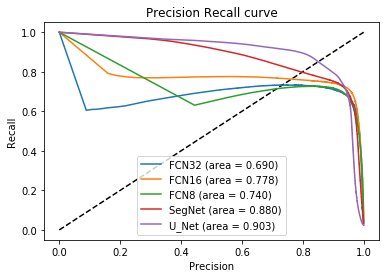

In [17]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(tpr_32, fpr_32, label='FCN32 (area = {:.3f})'.format(auc_32))
plt.plot(tpr_16, fpr_16, label='FCN16 (area = {:.3f})'.format(auc_16))
plt.plot(tpr_8, fpr_8, label='FCN8 (area = {:.3f})'.format(auc_8))
plt.plot(tpr_SegNet, fpr_SegNet, label='SegNet (area = {:.3f})'.format(auc_SegNet))
plt.plot(tpr_U_Net, fpr_U_Net, label='U_Net (area = {:.3f})'.format(auc_U_Net))

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.savefig("white_PRcurve")
plt.show()

# ROC Curve

In [18]:
from sklearn.metrics import roc_curve

y_pred_32 = pred_32.ravel()
y_pred_16 = pred_16.ravel()
y_pred_8 = pred_8.ravel()
y_pred_SegNet = pred_SegNet.ravel()
y_pred_U_Net = pred_U_Net.ravel()

Y_test = batch_mask.ravel()
#batch_mask= np.reshape(batch_mask,np.shape(y_pred_32))

fpr_32, tpr_32, thresholds_32 = roc_curve(Y_test, y_pred_32)
fpr_16, tpr_16, thresholds_16 = roc_curve(Y_test, y_pred_16)
fpr_8, tpr_8, thresholds_8 = roc_curve(Y_test, y_pred_8)
fpr_SegNet, tpr_SegNet, thresholds_SegNet = roc_curve(Y_test, y_pred_SegNet)
fpr_U_Net, tpr_U_Net, thresholds_U_Net = roc_curve(Y_test, y_pred_U_Net)

auc_32= auc(fpr_32, tpr_32)
auc_16= auc(fpr_16, tpr_16)
auc_8= auc(fpr_8, tpr_8)
auc_SegNet= auc(fpr_SegNet, tpr_SegNet)
auc_U_Net= auc(fpr_U_Net, tpr_U_Net)

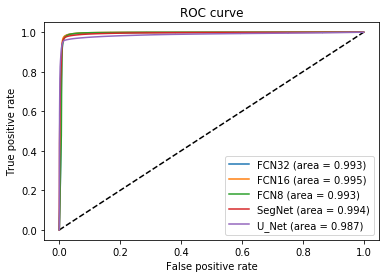

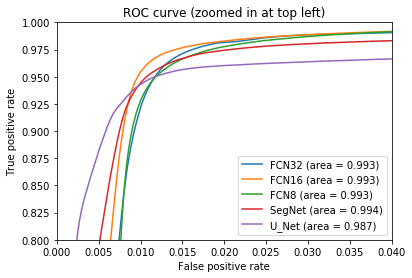

In [19]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_32, tpr_32, label='FCN32 (area = {:.3f})'.format(auc_32))
plt.plot(fpr_16, tpr_16, label='FCN16 (area = {:.3f})'.format(auc_16))
plt.plot(fpr_8, tpr_8, label='FCN8 (area = {:.3f})'.format(auc_8))
plt.plot(fpr_SegNet, tpr_SegNet, label='SegNet (area = {:.3f})'.format(auc_SegNet))
plt.plot(fpr_U_Net, tpr_U_Net, label='U_Net (area = {:.3f})'.format(auc_U_Net))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("white_ROC")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.04)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_32, tpr_32, label='FCN32 (area = {:.3f})'.format(auc_32))
plt.plot(fpr_16, tpr_16, label='FCN16 (area = {:.3f})'.format(auc_32))
plt.plot(fpr_8, tpr_8, label='FCN8 (area = {:.3f})'.format(auc_32))
plt.plot(fpr_SegNet, tpr_SegNet, label='SegNet (area = {:.3f})'.format(auc_SegNet))
plt.plot(fpr_U_Net, tpr_U_Net, label='U_Net (area = {:.3f})'.format(auc_U_Net))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig("white_ROC_zoomed")
plt.show()